**安装torchcam**

In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 361.6 kB/s eta 0:00:00


**导包**

In [ ]:
import os
import time
import random
import numpy as np
import torch
import cv2
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

**展示图片**

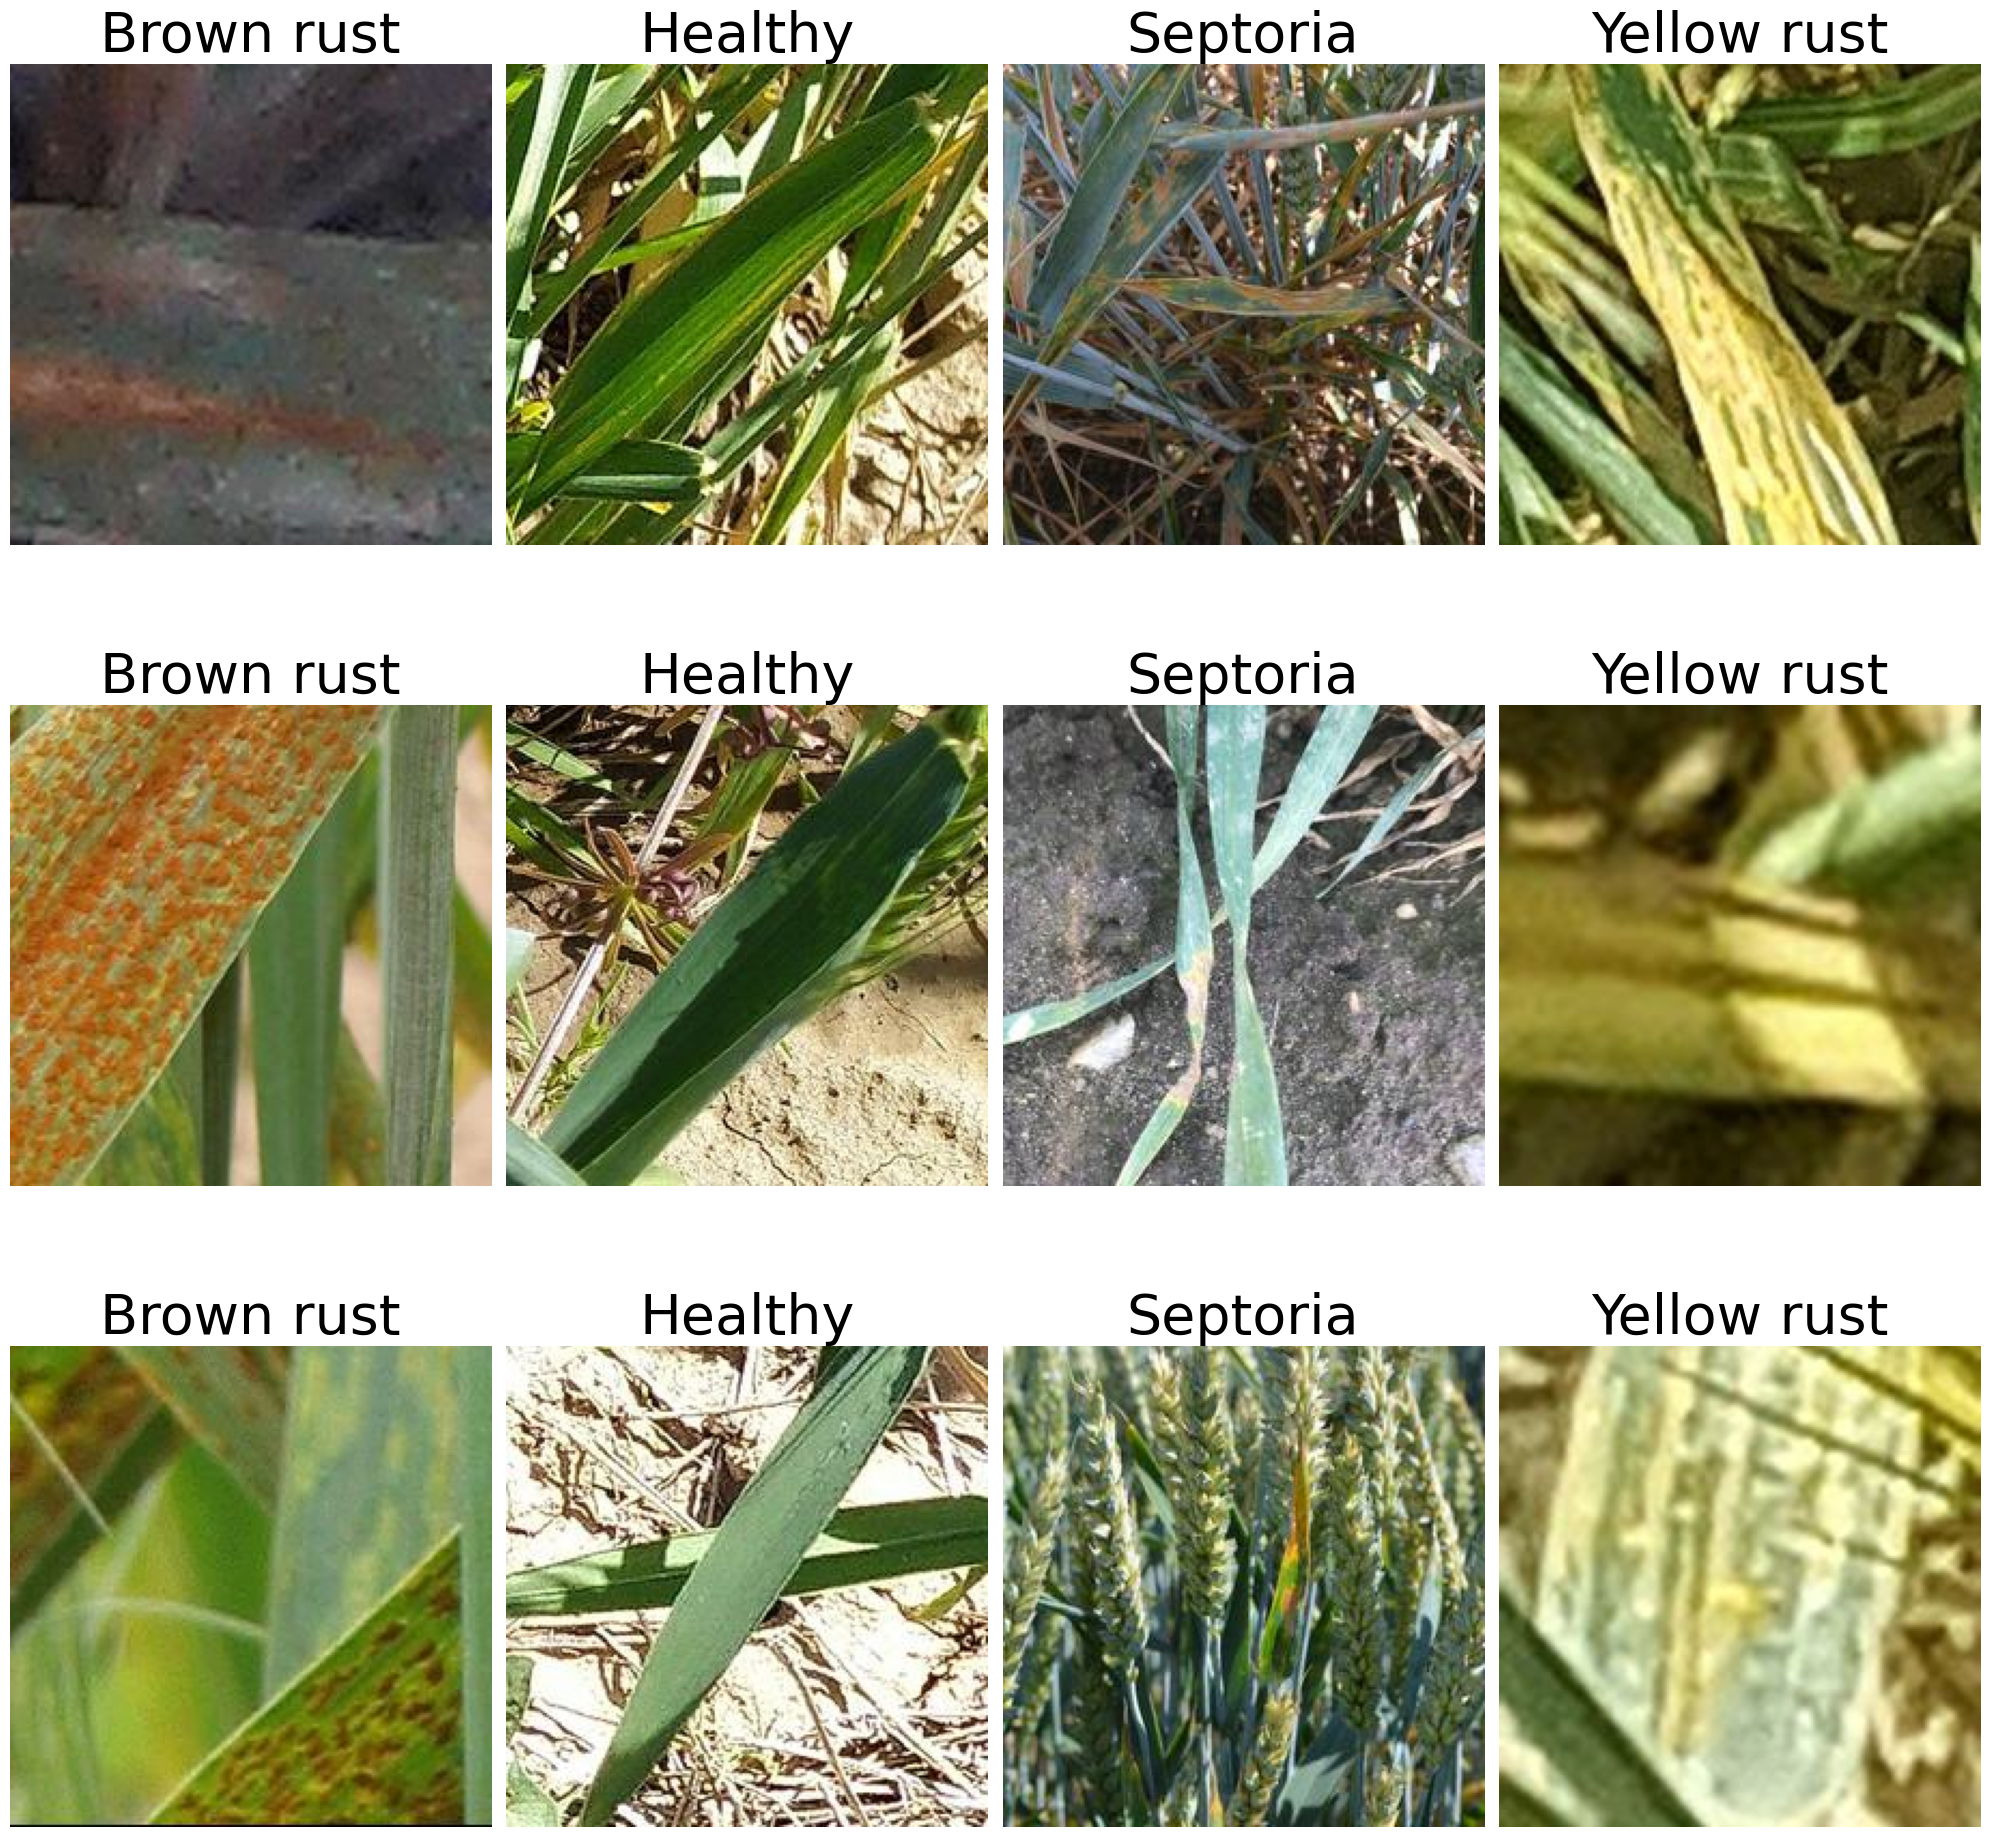

In [ ]:
# 定义文件夹路径
folders = ['Brown_rust', 'Healthy', 'Septoria', 'Yellow_rust']
parent_directory = './data/wheat-leaf-disease/after/train'

# 定义目标尺寸
target_size = 224

# 创建一个 Matplotlib subplot 网格
fig, axs = plt.subplots(3, len(folders), figsize=(20, 20))

# 遍历每个文件夹
for j, folder in enumerate(folders):
    folder_path = os.path.join(parent_directory, folder)

    # 获取文件夹中的所有图像文件
    image_files = [file for file in os.listdir(folder_path) if file.endswith((".jpg", ".png"))]

    # 从中随机选择3张图像
    selected_images = random.sample(image_files, min(3, len(image_files)))

    # 遍历所选的图像
    for i, file in enumerate(selected_images):
        file_path = os.path.join(folder_path, file)

        # 读取并处理图像
        img = Image.open(file_path)

        # 显示图像
        axs[i, j].imshow(img)
        axs[i, j].axis('off')  # 关闭坐标轴
        axs[i, j].set_title(folder.replace('_',' '),fontsize=40)

# 调整 subplot 布局
plt.tight_layout()
plt.show()

**制作数据集**

In [ ]:
class_labels = ('Brown_rust', 'Healthy', 'Septoria', 'Yellow_rust')

# 定义数据转换
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# 生成索引
def make_txt(root, file_name, label):
    path = os.path.join(root, file_name)

    # 选择打开的文件
    if 'train' in root:
        file_path = os.path.join(root, 'train_data.txt')

    if 'test' in root:
        file_path = os.path.join(root, 'test_data.txt')

    with open(file_path, 'a') as f:
        data = os.listdir(path)
        for line in data:
            f.write(line + ' ' + str(label) + ' ' + file_name + '\n')


# 数据集路径
train_path = r'./data/wheat-leaf-disease/after/train'
test_path = r'./data/wheat-leaf-disease/after/test'

# 生成索引文件
for index, value in enumerate(class_labels):
    make_txt(train_path, file_name=value, label=index)
    make_txt(test_path, file_name=value, label=index)



# 读取训练集索引构成DataSet
class WheatLeafBaseDataset(Dataset):
    def __init__(self, img_path, split, transform=None):
        super(WheatLeafBaseDataset, self).__init__()
        self.root = img_path
        self.split = split
        self.txt_root = os.path.join(self.root, self.split, f'{self.split}_data.txt')
        f = open(self.txt_root, 'r')
        data = f.readlines()
        imgs = []
        labels = []
        for line in data:
            line = line.rstrip()
            word = line.split()
            imgs.append(os.path.join(self.root, self.split, word[2], word[0]))
            labels.append(word[1])
        self.img = imgs
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        img = self.img[item]
        label = self.label[item]
        img = Image.open(img).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        label = np.array(label).astype(np.int64)
        label = torch.from_numpy(label)
        return img, label


class WheatLeafTrainDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafTrainDataset, self).__init__(img_path, 'train', transform)


class WheatLeafTestDataset(WheatLeafBaseDataset):
    def __init__(self, img_path, transform=None):
        super(WheatLeafTestDataset, self).__init__(img_path, 'test', transform)

path = r'./data/wheat-leaf-disease/after'

train_dataset = WheatLeafTrainDataset(path, transform=transforms)
test_dataset = WheatLeafTestDataset(path, transform=transforms)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
def get_mean_std(loader):
    # Var[x] = E[X**2]-E[X]**2
    channels_sum,channels_squared_sum,num_batches = 0,0,0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    print(num_batches)
    print(channels_sum)
    mean = channels_sum/num_batches #计算每个通道的平均像素值
    std = (channels_squared_sum/num_batches - mean**2) **0.5 #计算每个通道的像素值的标准差

    return mean,std

mean,std = get_mean_std(train_data_loader)

print(f'Mean: {mean.tolist()}')
print(f'Std: {std.tolist()}')



with open('./mean&std/mean&std.txt', 'w') as file:
    file.write(f'Mean: {mean.tolist()}\n')
    file.write(f'Std: {std.tolist()}\n')

52
tensor([24.7826, 25.1656, 15.4185])
Mean: [0.47658777236938477, 0.48395389318466187, 0.29650986194610596]
Std: [0.250182181596756, 0.23889385163784027, 0.22198860347270966]


In [ ]:
p = 1.0
scale = (0.2, 0.3)
ratio = (0.5, 1.0)
value = (0, 0, 255)
brightness = (1, 10)
contrast = (1, 10)
saturation = (1, 10)
hue = (0.2, 0.4)
size = (256, 256)
scale=(0.8, 1.0)
ratio=(0.75, 1.0)

# 数据预处理
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=size, scale=scale, ratio=ratio),# 随机大小裁剪和缩放
    transforms.RandomVerticalFlip(1),# 随机垂直翻转
    transforms.RandomErasing(p=p, scale=scale, ratio=ratio, value=value),# 随机擦除
    transforms.ColorJitter(brightness, contrast, saturation, hue),# 调整颜色
    transforms.RandomHorizontalFlip(0.5),# 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4764561653137207, 0.48394930362701416, 0.29640254378318787],
        std=[0.2501216530799866, 0.23886951804161072, 0.22192639112472534]
    ) # 标准化
])

 **修改模型**

In [ ]:
model = models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**EfficientNet时候使用**

In [ ]:
!pip install efficientnet-pytorch

from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7')

# model = EfficientNet.from_name('efficientnet-b7')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a9f53f8f724b7d2c17a6f67e27dfab62651d4510bc148d480e7e31d8f176caed
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


**冻结模型参数**

In [ ]:
for para in model.parameters():
    para.requires_grad = False

**使用DenseNet121时修改模型**

In [ ]:
# 获取原始分类器（classifier）的输入特征数
in_features = model.classifier.in_features

# 修改最后一层全连接层
model.classifier = nn.Linear(in_features, 4)

**使用GoogleNet、ResNet18时修改模型**

In [ ]:
# 获取原始分类器（fc）的输入特征数
in_features = model.fc.in_features

# 修改最后一层全连接层
model.fc = nn.Linear(in_features, 4)

**使用VGG11、AlexNet、MobilenetV3时修改模型**

In [ ]:
# 获取原始分类器（fc）的输入特征数
in_features = model.classifier[-1].in_features

# 修改最后一层全连接层
model.classifier[-1] = nn.Linear(in_features, 4)

**EfficientNet_b7时修改模型**

In [ ]:
model._fc= torch.nn.Linear(in_features=model._fc.in_features, out_features=4, bias=True)

**将模型移动至GPU**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

**查看模型内存信息**

In [ ]:
num_parameters = sum(p.numel() for p in model.parameters())
size_in_bytes = num_parameters * 4
memory = size_in_bytes / 1024**2
print('Model memory:',memory)

Model memory: 45.71528625488281


**修改训练epochs和下降率**

In [ ]:
# 定义损失函数和优化器，修改权重比
# 计算类别权重
y_all = []  # 保存所有训练集的标签
for img, labels in train_data_loader:
    y_all.extend(labels.numpy())

class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y_all),y = y_all)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, min_lr=0.00000000001)

# 训练模型
num_epochs = 10

In [ ]:
import time

loss_list = []
acc_list = []
sum_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    for inputs, labels in train_data_loader:
        y=labels
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        # loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
    # 在测试集上评估模型
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    loss_list.append(loss.item())
    acc_list.append(accuracy)
    scheduler.step(accuracy)
    end_time = time.time()
    epoch_time = end_time - start_time
    sum_time += epoch_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f} seconds")

# 保存训练好的模型
torch.save(model.state_dict(), './model/AlexNettransfer_learning-wheatleafdiesas_transfer_learningModel.pth')

# 保存loss
with open('./Loss_and_acc_result/CNN_loss.txt', 'w') as file:
    for loss in loss_list:
        file.write(str(loss) + '\n')

# 保存accuracy
with open('./Loss_and_acc_result/CNN_accuracy.txt', 'w') as file:
    for acc in acc_list:
        file.write(str(acc) + '\n')
# 保存总时间
with open('./CNN_times.txt', 'w') as file:
    file.write(str(sum_time))

Epoch 1/10, Loss: 0.9869, Test Accuracy: 0.2668, Time: 104.14 seconds
Epoch 2/10, Loss: 1.0737, Test Accuracy: 0.2668, Time: 105.64 seconds
Epoch 3/10, Loss: 1.1008, Test Accuracy: 0.2668, Time: 106.21 seconds
Epoch 4/10, Loss: 1.0878, Test Accuracy: 0.2788, Time: 106.39 seconds
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/10, Loss: 1.0358, Test Accuracy: 0.2668, Time: 107.01 seconds
Epoch 6/10, Loss: 1.1853, Test Accuracy: 0.2668, Time: 106.80 seconds
Epoch 7/10, Loss: 1.1212, Test Accuracy: 0.2668, Time: 107.30 seconds
Epoch 8/10, Loss: 1.0476, Test Accuracy: 0.2668, Time: 107.01 seconds
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 9/10, Loss: 0.9653, Test Accuracy: 0.2668, Time: 107.26 seconds
Epoch 10/10, Loss: 1.0698, Test Accuracy: 0.2668, Time: 106.75 seconds


获取整个程序执行期间 GPU 内存的最大总量

In [ ]:
max_memory = torch.cuda.max_memory_allocated()
print(f"Max GPU Memory Allocated: {max_memory / 1024**3} GB")

Max GPU Memory Allocated: 0.5378212928771973 GB


绘制Loss和Accuracy曲线

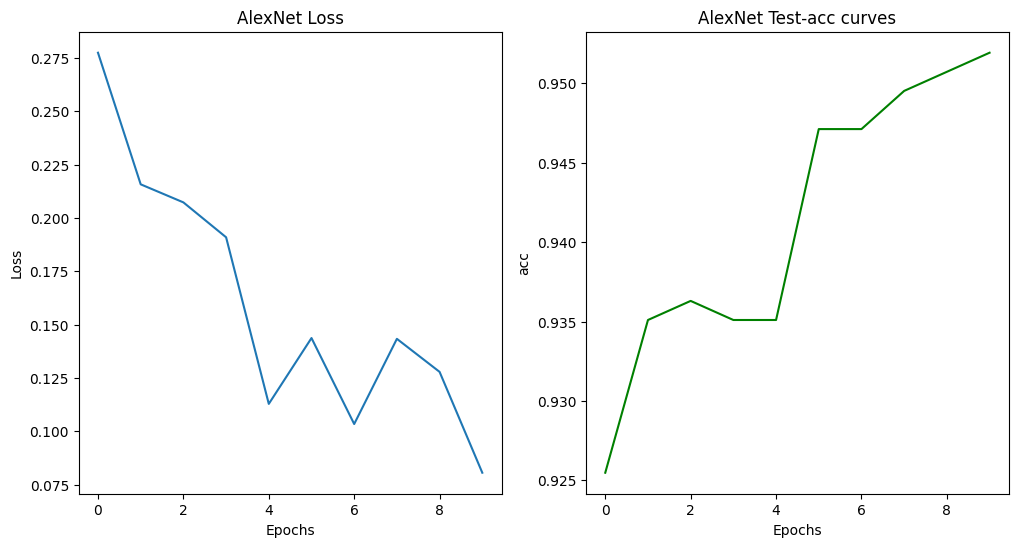

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 子图1：损失曲线
plt.subplot(121)
plt.plot(loss_list)
plt.title('AlexNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 子图2：准确率曲线
plt.subplot(122)
plt.plot(acc_list, color='green')
plt.title('AlexNet Test-acc curves')
plt.xlabel('Epochs')
plt.ylabel('acc')

# 保存整个图形为一张图片
plt.savefig('AlexNet_transfer_learning.jpg')

plt.show()

释放缓存分配器当前所管理的所有未使用的缓存

In [ ]:
torch.cuda.empty_cache()

预处理

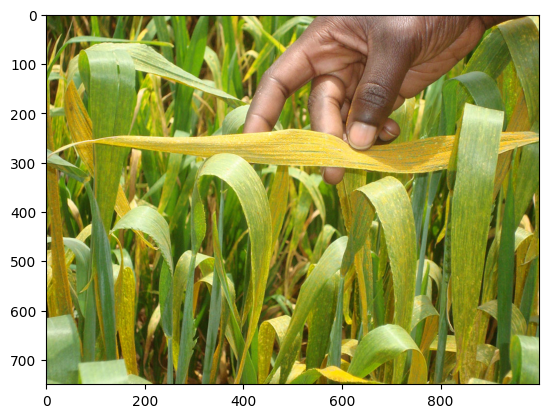

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4764561653137207, 0.48394930362701416, 0.29640254378318787], [0.2501216530799866, 0.23886951804161072, 0.22192639112472534])
])

im = cv2.imread('./data/R.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
height, width, channel = im.shape
labels = {'Brown_rust': 0, 'Healthy': 1, 'Septoria': 2, 'Yellow_rust': 3}
plt.imshow(im)
plt.show()

修改模型

In [ ]:
net = models.densenet121(pretrained=False)

In [ ]:
net = EfficientNet.from_name('efficientnet-b7')

In [ ]:
in_features = net.fc.in_features
net.fc = nn.Linear(in_features, 4)

In [ ]:
in_features = net.classifier[-1].in_features
net.classifier[-1] = nn.Linear(in_features, 4)

In [ ]:
in_features = net.fc.in_features
net.fc = nn.Linear(in_features, 4)

In [ ]:
in_features = net.classifier.in_features
net.classifier = nn.Linear(in_features, 4)

In [ ]:
net._fc = torch.nn.Linear(in_features=net._fc.in_features, out_features=4, bias=True)

加载模型

In [ ]:
net.load_state_dict(torch.load(r'./model/DenseNet121transfer_learning-wheatleafdiesas_transfer_learningModel.pth'))

<All keys matched successfully>

加载GoogleNet模型时

In [ ]:
missing_keys, unexpected_keys = net.load_state_dict(torch.load('/content/drive/MyDrive/PytorchTest/model/GoogleNettransfer_learning-wheatleafdiesas_transfer_learningModel.pth',
                                                               map_location=device),
                                                              strict=False)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
net.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

查看预处理后的图片

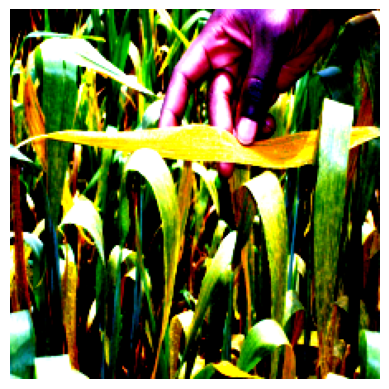

torch.Size([1, 3, 224, 224])


In [ ]:
# 使用多个样本进行SmoothGradCAMpp提取
cam_extractor = SmoothGradCAMpp(net)

img_pil = Image.open('/content/drive/MyDrive/PytorchTest/data/R.png').convert('RGB')
input_tensor = transform(img_pil).unsqueeze(0).to(device)

# 将张量转换回numpy数组
preprocessed_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

print(input_tensor.shape)

绘制CAM图

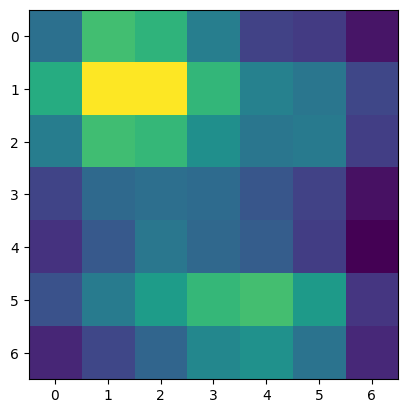

In [ ]:
# 运行神经网络，得到预测的logits
pred_logits = net(input_tensor)

# 使用torch.topk找到logits中的最大值及其对应的索引
pred_top1 = torch.topk(pred_logits, 1) # 找到张量中的前 1 个最大值及其对应的索引

# 从索引张量中获取预测的类别ID
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

# 利用cam_extractor函数生成激活热图
activation_map = cam_extractor(pred_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()

# 显示激活热图
plt.imshow(activation_map)
plt.show()

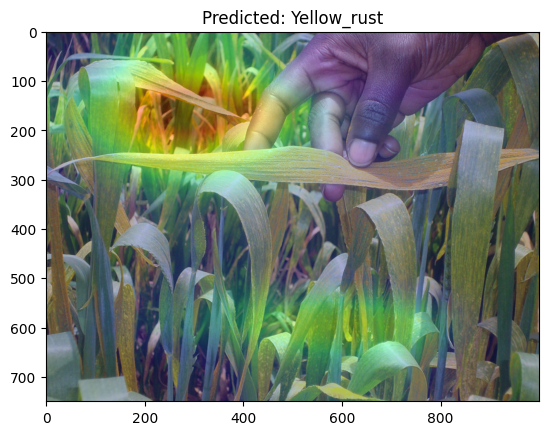

In [ ]:
# 将激活热图叠加到原始图像上
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

# 显示结果图像
fig, ax = plt.subplots(1, 1)
ax.set_title('Predicted: ' + class_labels[pred_id])
ax.imshow(result)
plt.show()

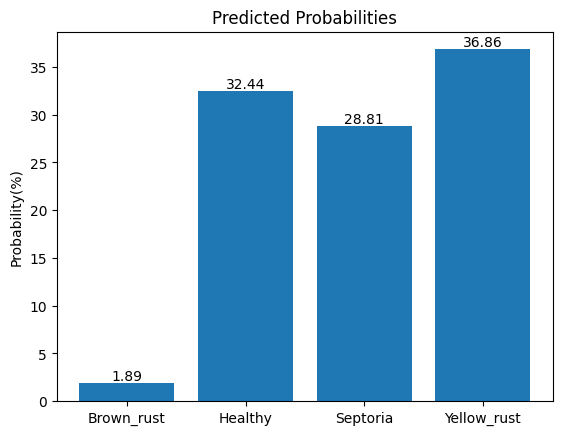

In [ ]:
img = Image.open('./data/R.png').convert('RGB')
img = transform(img)
img = torch.unsqueeze(img, dim=0)
img = img.to(device)

with torch.no_grad():
  output = net(img)
  probs = nn.functional.softmax(output, dim=1)
  pred_prob, pred_label = torch.max(probs, 1)

probs = probs[0].cpu().numpy() * 100  # 将概率值转换为百分比

# 绘制柱状图
plt.bar(range(len(probs)), probs, tick_label=class_labels)
plt.ylabel('Probability(%)')
plt.title('Predicted Probabilities')

for i, prob in enumerate(probs):
    plt.text(i, prob + 0.01, f'{prob:.2f}', ha='center', va='bottom')

绘制混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.axis("equal")
    ax = plt.gca()
    left, right = plt.xlim()
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2%}'.format(cm[i, j]) if normalize else '{:d}'.format(int(cm[i, j]))
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('DenseNet121confusionmatrix.jpg',bbox_inches='tight', pad_inches=0.1, dpi=800) #保存
    plt.show()

Normalized confusion matrix
[[0.95945946 0.02702703 0.         0.01351351]
 [0.02597403 0.96428571 0.00649351 0.00324675]
 [0.         0.08571429 0.91428571 0.        ]
 [0.01293103 0.00431034 0.         0.98275862]]


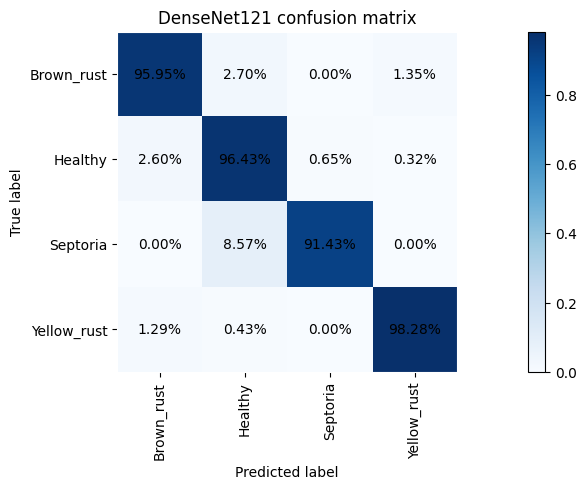

In [ ]:
# 在测试集上运行模型并收集预测结果和真实标签
all_preds = []
all_labels = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='DenseNet121 confusion matrix')

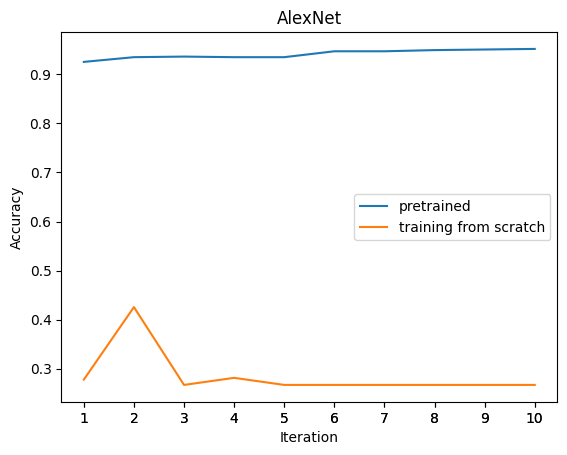

In [ ]:
x1, y1 = [], []
x2, y2 = [], []


def read_data(file_path, x, y):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            data_point = line.strip()

            # 将数据点添加到数组
            y.append(float(data_point))
            x.append(i + 1)


file_path1 = '/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/accuracy/AlexNet_accuracy.txt'
file_path2 = '/content/drive/MyDrive/PytorchTest/Loss_and_acc_result/AlexNet_not_transfer_learning_accuracy.txt'


read_data(file_path1, x1, y1)
read_data(file_path2, x2, y2)


plt.plot(x1, y1, label='pretrained')
plt.plot(x2, y2, label='training from scratch')


plt.title('AlexNet')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.xticks(x1 + x2, x1 + x2)


plt.legend()
plt.savefig('data/wheat-leaf-disease/accuracy_line_img/AlexNet.jpg', dpi=900)
plt.show()

性能图

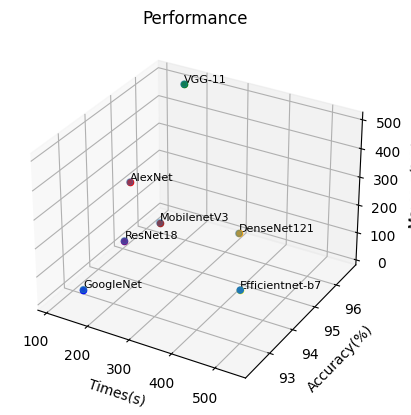

In [ ]:
point_names = ['AlexNet', 'VGG-11', 'GoogleNet', 'ResNet18', 'DenseNet121', 'Efficientnet-b7', 'MobilenetV3']


x = [109.667897,
     161.1042612,
     140.4423647,
     122.6961145,
     311.7152424,
     537.789294,
     132.0254643,
     ]

y = [0.951923077,
     0.966346154,
     0.927884615,
     0.947115385,
     0.963942308,
     0.923076923,
     0.960336538,
     ]

z = [217.5149078,
     491.2881012,
     21.37757874,
     42.64283752,
     26.54249573,
     243.3670197,
     16.23838806,
     ]

colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'brown']
y = [val * 100 for val in y]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(x)):
    ax.scatter(x[i], y[i], z[i], c=colors[i], label=point_names[i])
    ax.text(x[i], y[i], z[i], point_names[i], color='black', fontsize=8, ha='left', va='bottom')
ax.scatter(x, y, z)

ax.set_title('Performance')
ax.set_xlabel('Times(s)')
ax.set_ylabel('Accuracy(%)')
ax.set_zlabel('Memory(MB)')

plt.savefig('performance.jpg', dpi=800)

plt.show()